In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
from astropy.timeseries import LombScargle
from scipy.integrate import RK45, DOP853
from scipy.stats import chi2, iqr
from scipy.signal import argrelextrema
from scipy.spatial.distance import chebyshev

### Plotting code

In [2]:
def plotTimeSeries(t, y, min_freq=None, max_freq=None, nq=None, spp=10, true_freq=None, LS_xlim=None, plot_harmonics=False, title=None):
    frequency, power = LombScargle(t,y).autopower(minimum_frequency=min_freq, maximum_frequency=max_freq, nyquist_factor=nq, samples_per_peak=spp)
    
    fig = plt.figure(figsize=(16,8))
    gs = gridspec.GridSpec(2, 2, figure=fig)
    ax00 = fig.add_subplot(gs[0, :])
    ax00.plot(t, y)
    ax00.set_xlabel('time')
    ax00.set_ylabel('signal')
    if title is not None:
        ax00.set_title('{0} time series'.format(title))
    else:
        ax00.set_title('time series')

    ax10 = fig.add_subplot(gs[1, 0])
    ax10.hist(y,bins=30)
    ax10.set_xlabel('signal')
    ax10.set_ylabel('count')
    ax10.set_title('Histogram')


    ax11 = fig.add_subplot(gs[1, 1])
    ax11.plot(frequency, power)
    ax11.set_xlabel('frequency [cycles/time unit]')
    ax11.set_ylabel('power [dimensionless]')
    ax11.set_title('Lomb-Scargle periodogram')
    if LS_xlim is not None:
        ax11.set_xlim(LS_xlim)
    if true_freq is not None:
        [ax11.axvline(x, color='r',lw=0.5) for x in true_freq]
        if plot_harmonics is True:
            [ax11.axvline(x, color='b',lw=0.5) for x in true_freq/2.]
            [ax11.axvline(x, color='g',lw=0.5) for x in true_freq/3.]
        
    plt.show()
    return 

### Gaussian noise

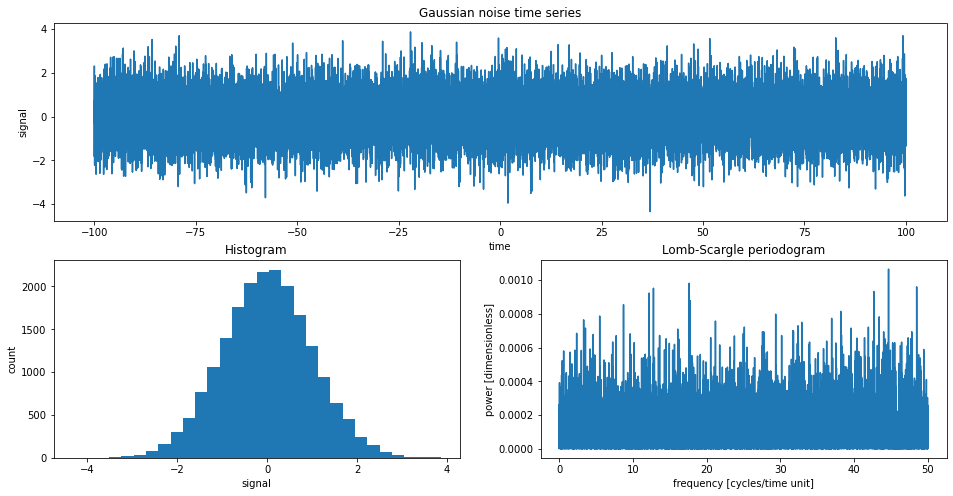

In [41]:
np.random.seed(8421)

dt = 0.01
tmin = -100.
tmax = 100.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

gaussianNoise = np.random.normal(0.,1.,len(t))
plotTimeSeries(t, gaussianNoise,min_freq=(1./baseline),max_freq=(1./(2.*dt)),title="Gaussian noise")

### Multiperiodic signals

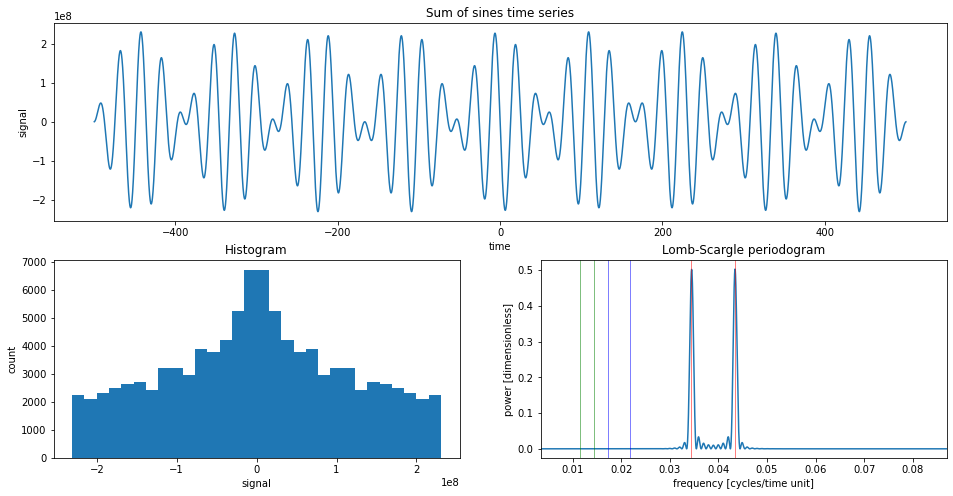

In [4]:
dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

v1 = 2*np.pi*(1./23.)
v2 = 2*np.pi*(1./29.)

trueFreqs = np.array((1./23.,1./29.))

simplePeriodic = (np.sin(t*v1) + np.sin(t*v2))
simplePeriodic = simplePeriodic/np.mean(simplePeriodic)
plotTimeSeries(t, simplePeriodic,min_freq=(1./baseline),max_freq=(1./(2.*dt)), nq=10, spp=100, 
               LS_xlim = (0.1*np.min(trueFreqs),2*np.max(trueFreqs)), plot_harmonics=True, 
               true_freq=trueFreqs,title="Sum of sines")

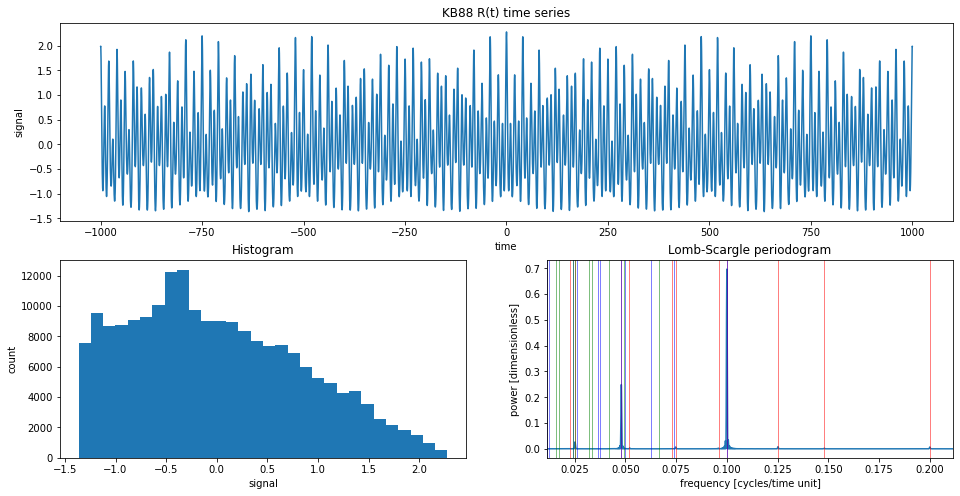

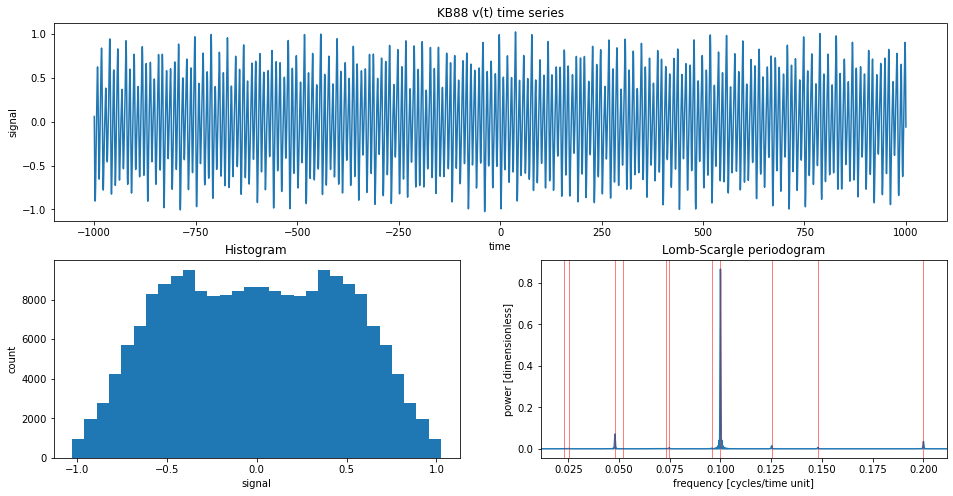

In [5]:
# multi-periodic signal from Kovacs & Buchler 1988
def KB88(t,a1=1.0,a2=0.6,a3=0.2,v1=0.1,v2=0.048,v3=0.0252):
    w1 = 2*np.pi*v1
    w2 = 2*np.pi*v2
    w3 = 2*np.pi*v3
    
    # length t + 1
    t2 = np.append(t, t[-1] + np.mean(t[1:] - t[0:-1]))
    
    r = a1 * np.cos(w1 * t2) + a2 * np.cos(w2 * t2) + a3 * np.cos(w3 * t2) \
        + 0.5 * a1 * a3 * (np.cos( (w1 + w3) * t2) + np.cos( (w1 - w3) * t2)) \
        + 0.1 * a2 * a3 * (np.cos( (w2 + w3) * t2) + np.cos( (w2 - w3) * t2)) \
        + 0.1 * a1 * a2 * (np.cos( (w1 + w2) * t2) + np.cos( (w1 - w2) * t2)) \
        + 0.1 * a1**2 * np.cos(2. * w1 * t2) \
        + 0.1 * a2**2 * np.cos(2. * w2 * t2)
    
    v = (r[1:] - r[0:-1])/np.mean(t[1:] - t[0:-1])
        
    return r[:-1], v

dt = 0.01
tmin = -1000.
tmax = 1000.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

multiPeriodic_r, multiPeriodic_v = KB88(t)

trueFreqs = np.array((0.1, 0.048, 0.0252, 0.1+0.048, 0.1-0.048, 0.048+0.0252, 0.048-0.0252, 0.1+0.0252, 0.1-0.0252, 2*0.1, 2*0.048,))

plotTimeSeries(t, multiPeriodic_r, min_freq=0.5*np.min(trueFreqs),max_freq=np.max(trueFreqs)+0.5*np.min(trueFreqs), nq=10, spp=100, 
               LS_xlim = (0.5*np.min(trueFreqs),np.max(trueFreqs)+0.5*np.min(trueFreqs)), true_freq=trueFreqs, plot_harmonics=True, title="KB88 R(t)")
plotTimeSeries(t, multiPeriodic_v, min_freq=0.5*np.min(trueFreqs),max_freq=np.max(trueFreqs)+0.5*np.min(trueFreqs), nq=10, spp=100, 
               LS_xlim = (0.5*np.min(trueFreqs),np.max(trueFreqs)+0.5*np.min(trueFreqs)), true_freq=trueFreqs, title="KB88 v(t)")

### Rossler system 

In [6]:
def Rossler_FPs(a,b,c):
    x1 = (c + np.sqrt(c**2 - 4*a*b))/2.
    y1 = (-c - np.sqrt(c**2 - 4*a*b))/(2.*a)
    z1 = (c + np.sqrt(c**2 - 4*a*b))/(2.*a)
    
    x2 = (c - np.sqrt(c**2 - 4*a*b))/2.
    y2 = (-c + np.sqrt(c**2 - 4*a*b))/(2.*a)
    z2 = (c - np.sqrt(c**2 - 4*a*b))/(2.*a)
    
    return np.array((x1,y1,z1)), np.array((x2,y2,z2))

fp1, fp2 = Rossler_FPs(a=0.2,b=0.2,c=4.8)
print(fp1)
print(fp2)

[  4.79165215 -23.95826074  23.95826074]
[ 0.00834785 -0.04173926  0.04173926]


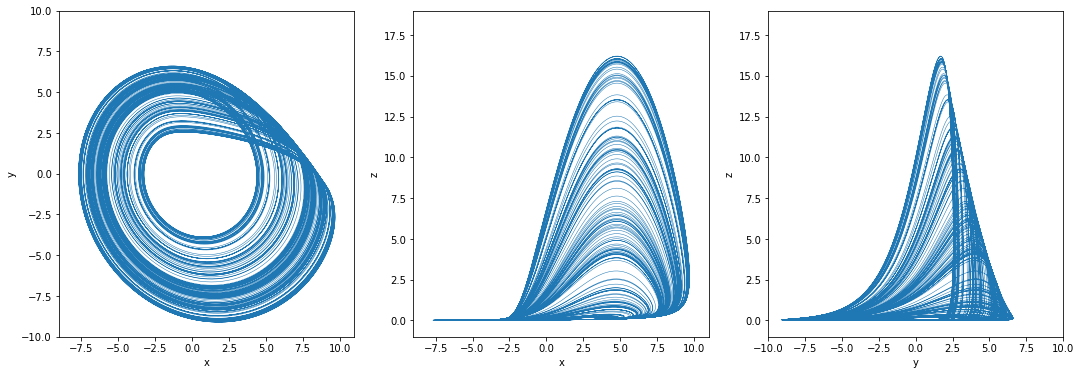

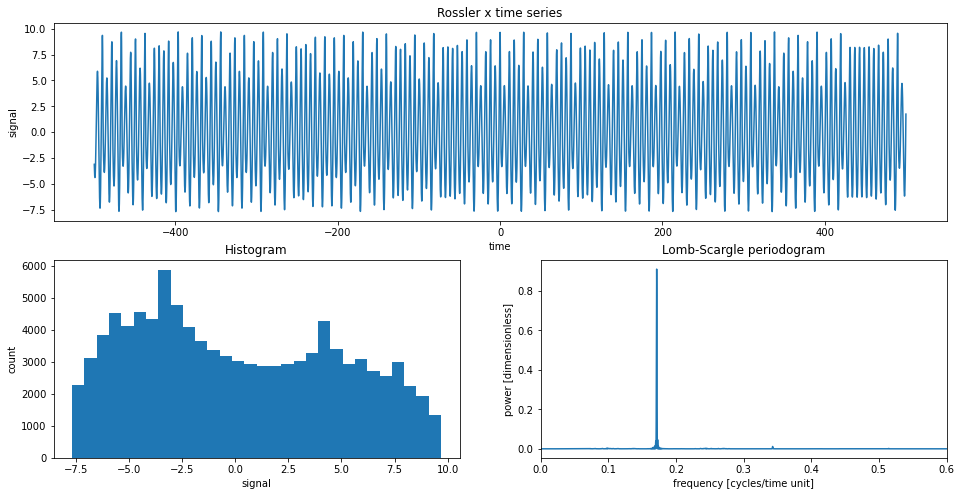

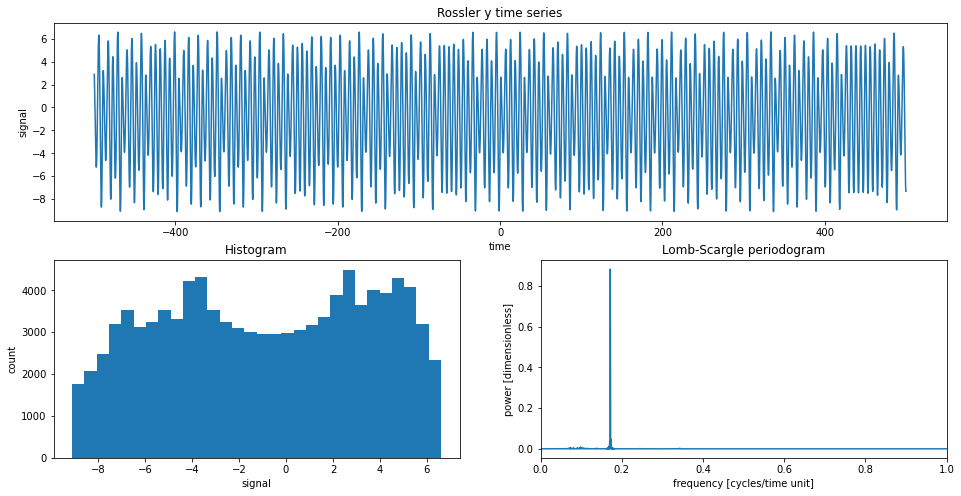

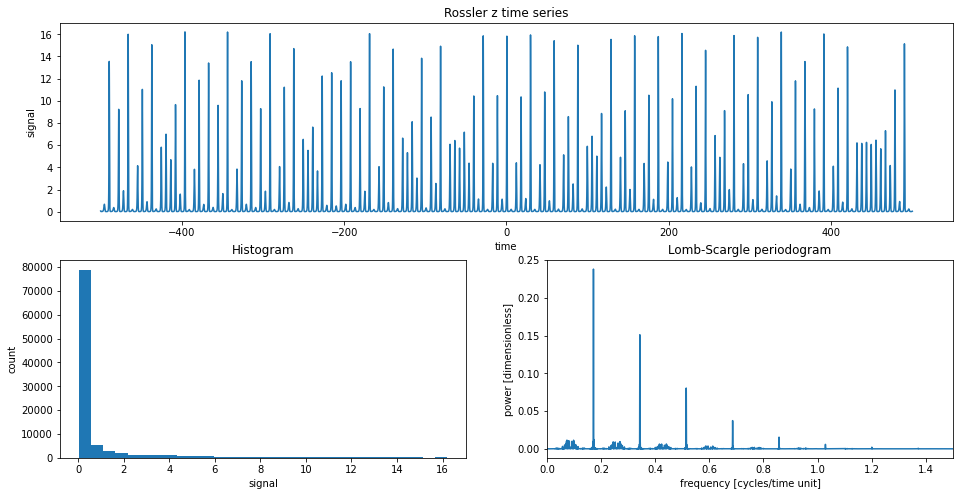

In [7]:
def Rossler_vel(t,r):
    """
    r is an array (x, y, z)
    return xdot, ydot, zdot
    """
    a=0.2
    b=0.2
    c=4.8
    
    x = r[0]
    y = r[1]
    z = r[2]
    
    v_x = -y - z
    v_y = x + a*y
    v_z = b + z*(x - c)
    
    return np.array((v_x, v_y, v_z))

#r0 = np.array((0.1, -7, 0.1))
# just in case, to avoid transients, choose as IC the 5000th iteration of the above IC
r0 = np.array((-3.07896671,  2.91997852,  0.07254192))

# fixed point experiment 
# need to do it this way because it's very very sensitive to ICs. truncation error is enough to ruin it
# (both unstable! trajectories roll off and down to the attractor.)
fp1_x = 4.79165215
fp1_y = -23.95826074
fp1_z = 23.95826074
#r0 = np.array((fp1_x, fp1_y, fp1_z))

fp2_x = 0.00834785
fp2_y = -0.04173926
fp2_z = 0.04173926
#r0 = np.array((fp2_x, fp2_y, fp2_z))

dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

rossler = RK45(fun=Rossler_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

rossler_r = np.empty((Nsteps,3))
rossler_t = np.empty((Nsteps))
for i in range(Nsteps):
    rossler.step()
    rossler_t[i] = rossler.t
    rossler_r[i] = rossler.y

#print(rossler_r[5000])

fig, axes = plt.subplots(1,3,figsize=(18,6))
axes[0].plot(rossler_r[:,0],rossler_r[:,1],lw=0.5)
axes[0].set_xlim(-9,11)
axes[0].set_ylim(-10,10)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[1].plot(rossler_r[:,0],rossler_r[:,2],lw=0.5)
axes[1].set_xlim(-9,11)
axes[1].set_ylim(-1,19)
axes[1].set_xlabel("x")
axes[1].set_ylabel("z")
axes[2].plot(rossler_r[:,1],rossler_r[:,2],lw=0.5)
axes[2].set_xlim(-10,10)
axes[2].set_ylim(-1,19)
axes[2].set_xlabel("y")
axes[2].set_ylabel("z")
plt.show()

plotTimeSeries(rossler_t,rossler_r[:,0],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,0.6),title="Rossler x")
plotTimeSeries(rossler_t,rossler_r[:,1],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,1.),title="Rossler y")
plotTimeSeries(rossler_t,rossler_r[:,2],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,1.5),title="Rossler z")

### Rotated Rossler system (inspired by Letellier & Aguirre 2002)

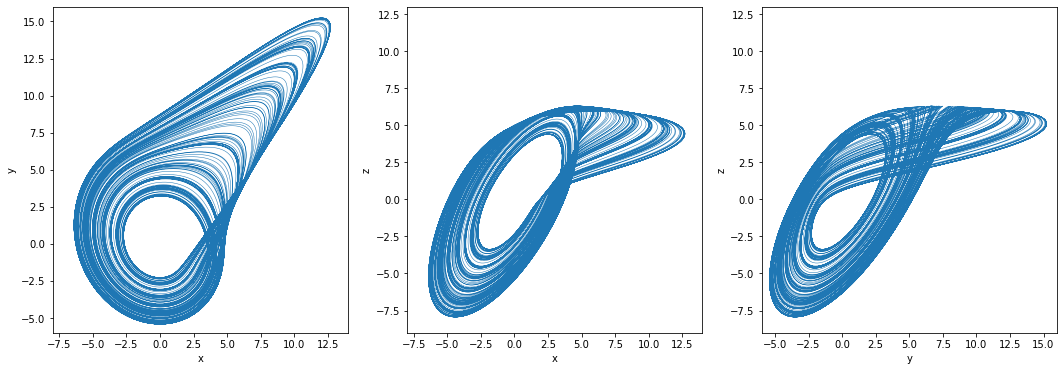

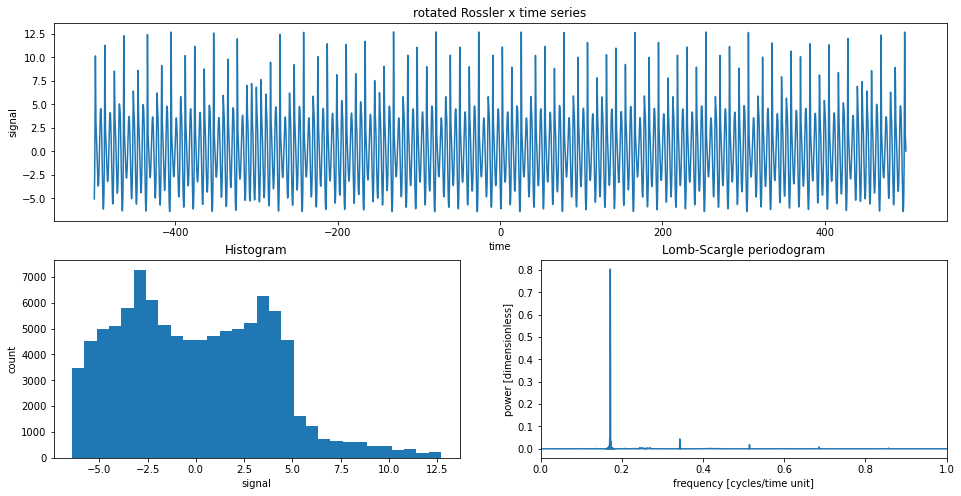

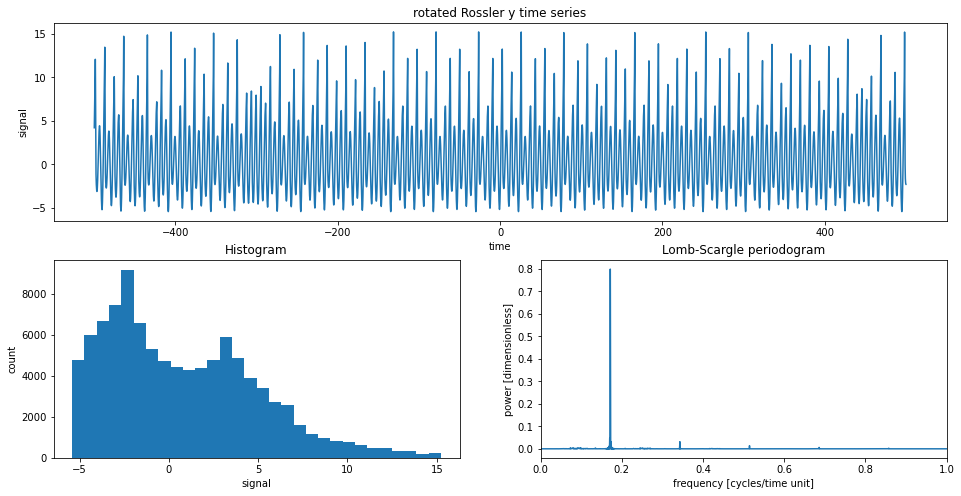

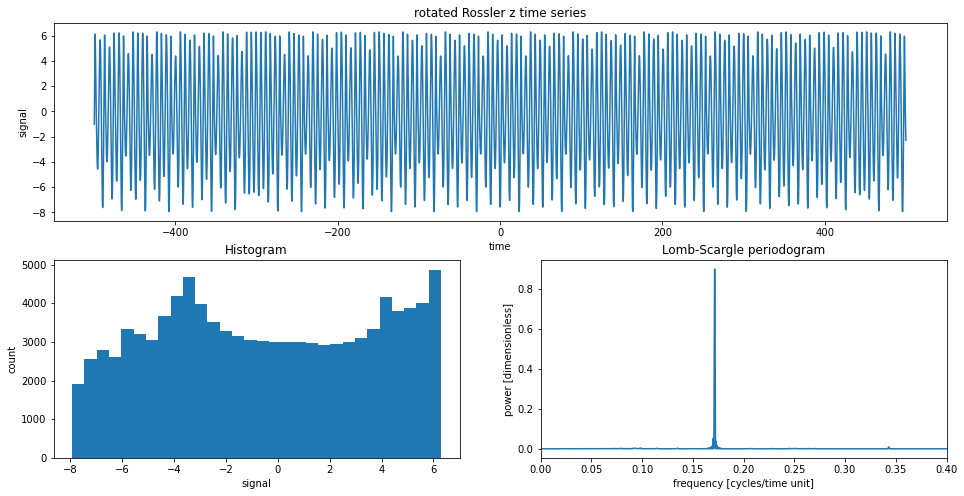

In [8]:
def rotated_Rossler_vel(t,r):
    """
    r is an array (x, y, z)
    return xdot, ydot, zdot
    """
    a=0.2
    b=0.2
    c=4.8
    
    x = r[0]
    y = r[1]
    z = r[2]
    
    # Note: equations (18) of Letellier & Aguirre 2002 are WRONG---these are right.
    #v_x = -0.5*((1 - a + c)*x + (a - 1 + c)*y - (1 + a + c)*z - 2*b) + 0.25*(x + y - z)*(z + y - x)
    #v_y = b + 0.25*(x + y - z)*(z + y - x - 2*c) - x
    #v_z = -x + 0.5*(x*(a - 1) + y*(1 - a) + z*(1 + a))
    
    #or, renormalizing by 1/sqrt(2): (i.e., x' = (1/sqrt(2))*(y+z), etc.
    v_x = 0.5*(x*(a - 1) + y*(1 - a) + z*(1 + a) + np.sqrt(2)*b + (x + y - z)*((np.sqrt(2)/2)*(y + z - x) - c))
    v_y = (1./np.sqrt(2))*b + 0.5*(x + y - z)*((np.sqrt(2)/2)*(z + y - x) - c) - x
    v_z = -x + 0.5*(x*(a - 1) + y*(1 - a) + z*(1 + a))
    
    return np.array((v_x, v_y, v_z))

#r0 = (1./np.sqrt(2))*np.array((2.9+0.07, 0.07-3.08, -3.08+2.9))
# just in case, to avoid transients, choose as IC the 5000th iteration of the above IC
r0 = np.array((-5.09005781,4.17054396,-1.09101873))
# fixed point experiment
# need to do it this way because it's very very sensitive to ICs. truncation error is enough to ruin it
# (both unstable! trajectories roll off and down to the attractor.)
fp1_x = 4.79165215
fp1_y = -23.95826074
fp1_z = 23.95826074
#r0 = (1./np.sqrt(2))*np.array((fp1_y + fp1_z, fp1_x+fp1_z, fp1_x+fp1_y))

fp2_x = 0.00834785
fp2_y = -0.04173926
fp2_z = 0.04173926
#r0 = (1./np.sqrt(2))*np.array((fp2_y + fp2_z, fp2_x+fp2_z, fp2_x+fp2_y))



dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

rotated_rossler = RK45(fun=rotated_Rossler_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

rotated_rossler_r = np.empty((Nsteps,3))
rotated_rossler_t = np.empty((Nsteps))
for i in range(Nsteps):
    rotated_rossler.step()
    rotated_rossler_t[i] = rotated_rossler.t
    rotated_rossler_r[i] = rotated_rossler.y
    #print(i, rotated_rossler_r[i])
#print(rotated_rossler_r[5000])

fig, axes = plt.subplots(1,3,figsize=(18,6))
axes[0].plot(rotated_rossler_r[:,0],rotated_rossler_r[:,1],lw=0.5)
axes[0].set_xlim(-8,14)
axes[0].set_ylim(-6,16)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[1].plot(rotated_rossler_r[:,0],rotated_rossler_r[:,2],lw=0.5)
axes[1].set_xlim(-8,14)
axes[1].set_ylim(-9,13)
axes[1].set_xlabel("x")
axes[1].set_ylabel("z")
axes[2].plot(rotated_rossler_r[:,1],rotated_rossler_r[:,2],lw=0.5)
axes[2].set_xlim(-6,16)
axes[2].set_ylim(-9,13)
axes[2].set_xlabel("y")
axes[2].set_ylabel("z")
plt.show()

plotTimeSeries(rotated_rossler_t,rotated_rossler_r[:,0],min_freq=(1./baseline),max_freq=(1./(2.*dt)), LS_xlim=(0.,1.),title="rotated Rossler x")
plotTimeSeries(rotated_rossler_t,rotated_rossler_r[:,1],min_freq=(1./baseline),max_freq=(1./(2.*dt)), LS_xlim=(0.,1.),title="rotated Rossler y")
plotTimeSeries(rotated_rossler_t,rotated_rossler_r[:,2],min_freq=(1./baseline),max_freq=(1./(2.*dt)), LS_xlim=(0.,0.4),title="rotated Rossler z")

### Lorenz system

In [9]:
def Lorenz_FPs(sigma, beta, rho):
    x1 = np.sqrt( beta * (rho - 1))
    y1 = x1
    z1 = rho - 1
    
    x2 = -x1
    y2 = -y1
    z2 = z1
    
    if rho < sigma*((sigma + beta + 3.)/(sigma - beta - 1.)):
        print("stable")
    else:
        print("unstable")
    
    return np.array((x1,y1,z1)), np.array((x2,y2,z2))

fp1, fp2 = Lorenz_FPs(sigma=10., beta=8./3., rho=28.)
print(fp1)
print(fp2)

unstable
[ 8.48528137  8.48528137 27.        ]
[-8.48528137 -8.48528137 27.        ]


In [10]:
def Lorenz_vel(t,r):
    """
    r is an array (x, y, z)
    return xdot, ydot, zdot
    """
    sigma=10.
    beta=8./3.
    rho=28.
    
    x = r[0]
    y = r[1]
    z = r[2]
    
    v_x = sigma*(y-x)
    v_y = x*(rho-z) - y
    v_z = x*y - beta*z
    
    return np.array((v_x, v_y, v_z))


#r0 = np.array((1., 1., 1.))
# the above IC isn't yet on the attractor, has a brief transient; the below is chosen as the 5000th iteration of the above
# and seems to be safely on the attractor
r0 = np.array((-13.29390985, -16.32060497,  29.90864944))


#fixed point experiments
# because rho > 1, expect 2 fixed points (at the center of the lobes)
# points are both stable if rho < sigma * ((sigma + beta + 3)/(sigma - beta - 1))
# given the choice of parameters above, the RHS of that inequality is ~= 24.7
# so we expect the two FPs to be *unstable*.
fp1_x = 8.48528137
fp1_y = 8.48528137
fp1_z = 27.

fp2_x = -fp1_x
fp2_y = -fp1_y
fp2_z = fp1_z

#r0 = np.array((fp1_x, fp1_y, fp1_z))
#r0 = np.array((fp2_x, fp2_y, fp2_z))

dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

lorenz = RK45(fun=Lorenz_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

lorenz_r = np.empty((Nsteps,3))
lorenz_t = np.empty((Nsteps))
for i in range(Nsteps):
    lorenz.step()
    lorenz_t[i] = lorenz.t
    lorenz_r[i] = lorenz.y


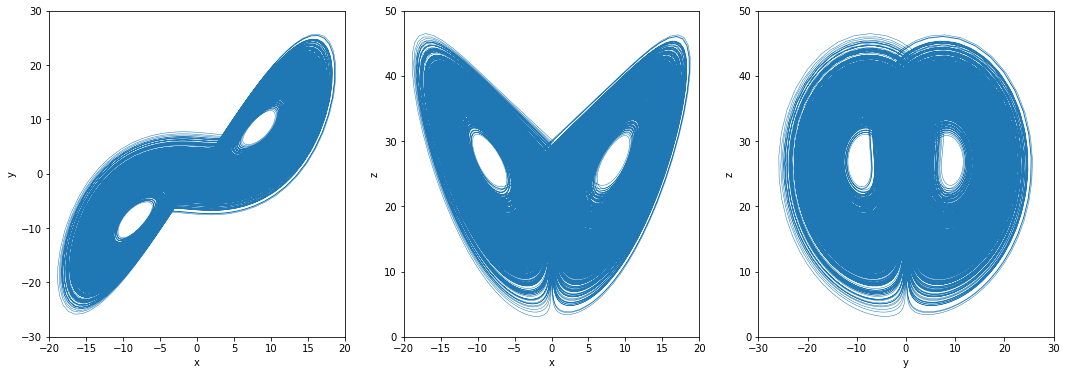

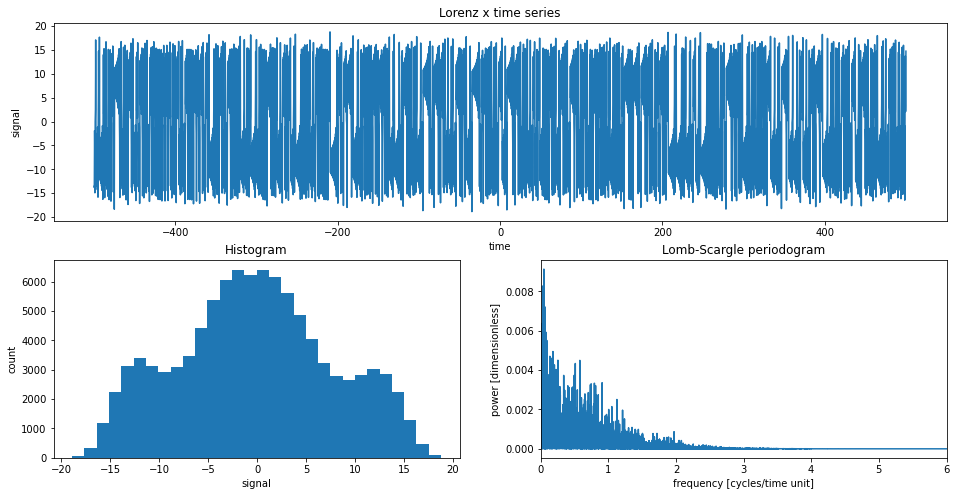

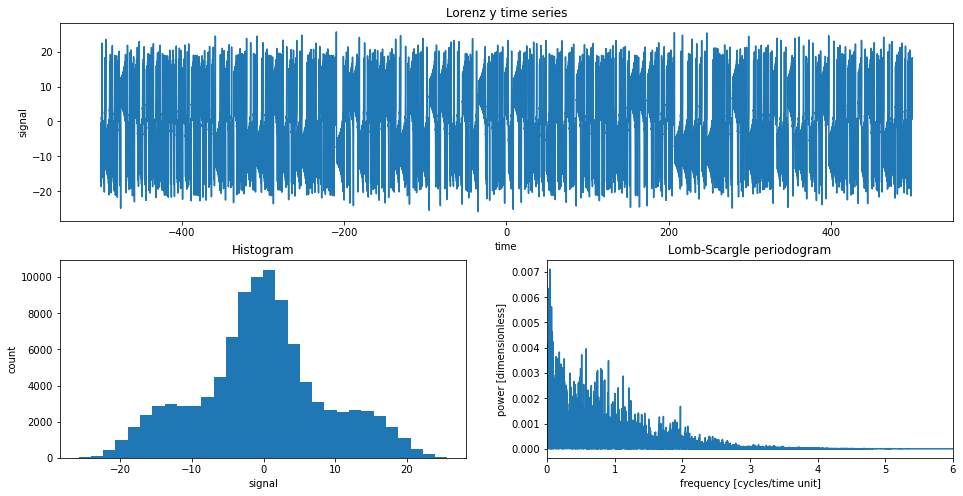

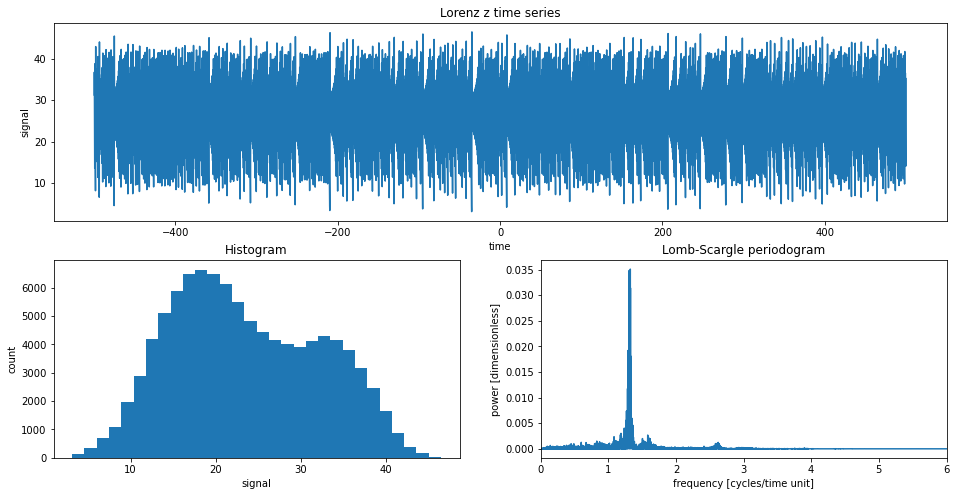

In [11]:
fig, axes = plt.subplots(1,3,figsize=(18,6))
axes[0].plot(lorenz_r[:,0],lorenz_r[:,1],lw=0.5)
axes[0].set_xlim(-20,20)
axes[0].set_ylim(-30,30)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[1].plot(lorenz_r[:,0],lorenz_r[:,2],lw=0.5)
axes[1].set_xlim(-20,20)
axes[1].set_ylim(0,50)
axes[1].set_xlabel("x")
axes[1].set_ylabel("z")
axes[2].plot(lorenz_r[:,1],lorenz_r[:,2],lw=0.5)
axes[2].set_xlim(-30,30)
axes[2].set_ylim(0,50)
axes[2].set_xlabel("y")
axes[2].set_ylabel("z")
plt.show()

plotTimeSeries(lorenz_t,lorenz_r[:,0],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,6.),title="Lorenz x")
plotTimeSeries(lorenz_t,lorenz_r[:,1],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,6.),title="Lorenz y")
plotTimeSeries(lorenz_t,lorenz_r[:,2],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,6.),title="Lorenz z")


## Number of data points 

In [12]:
print(np.shape(rossler_t))
print(np.shape(rossler_r))

(100000,)
(100000, 3)


In [13]:
print(np.shape(rotated_rossler_t))
print(np.shape(rotated_rossler_r))

(100000,)
(100000, 3)


In [14]:
print(np.shape(lorenz_t))
print(np.shape(lorenz_r))

(100000,)
(100000, 3)


# Choose time delay

### Fraser & Swinney 1986 (used 32,768 points for the Belousov-Zhabotinskii rxn; 1,048,576 points for the Rossler system)

### note: keep track of time taken per choice of delay time

In [15]:
# first, need a way of discretizing the data (X(t), X(t+T)) into 2D bins

def bin2D(timeSeries, tauIdx,plotTitle=None):
    x = timeSeries[:-tauIdx]
    y = timeSeries[tauIdx:]
    #print(timeSeries)
    #print(x)
    #print(y)
    fig, axes = plt.subplots(1,2,figsize=(13,6))
    axes[0].hist2d(x,y,bins=(100,100),cmap="Blues")
    axes[1].hexbin(x,y,gridsize=100,cmap="Blues",extent=(np.min(x)-0.01*np.ptp(x),np.max(x)+0.01*np.ptp(x),np.min(y)-0.01*np.ptp(y),np.max(y)+0.01*np.ptp(y)))
    for ax in axes:
        ax.set_aspect('equal')
        ax.set_xlabel("x[i]",fontsize=14)
        ax.set_ylabel("x[i + tauIdx]",fontsize=14)
        ax.set_xlim(np.min(x)-0.01*np.ptp(x), np.max(x)+0.01*np.ptp(x))
        ax.set_ylim(np.min(y)-0.01*np.ptp(y), np.max(y)+0.01*np.ptp(y))
    plt.suptitle(plotTitle,y=0.93,fontsize=16)
    
    return

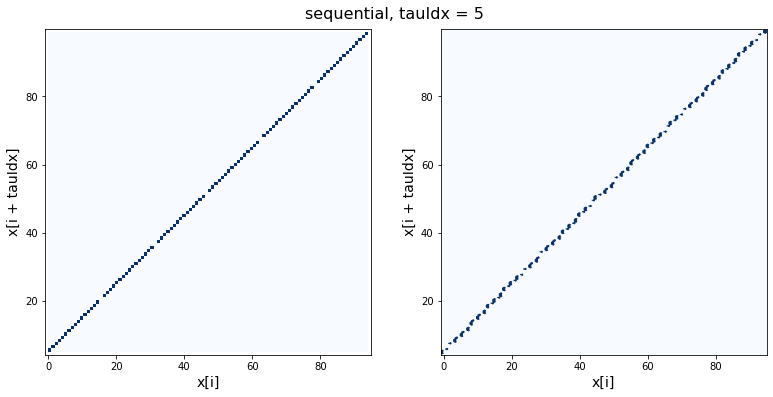

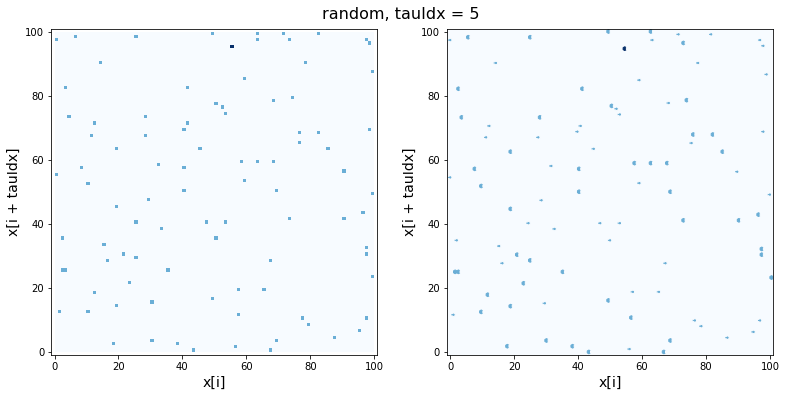

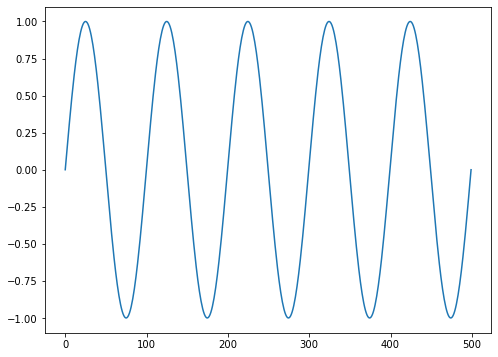

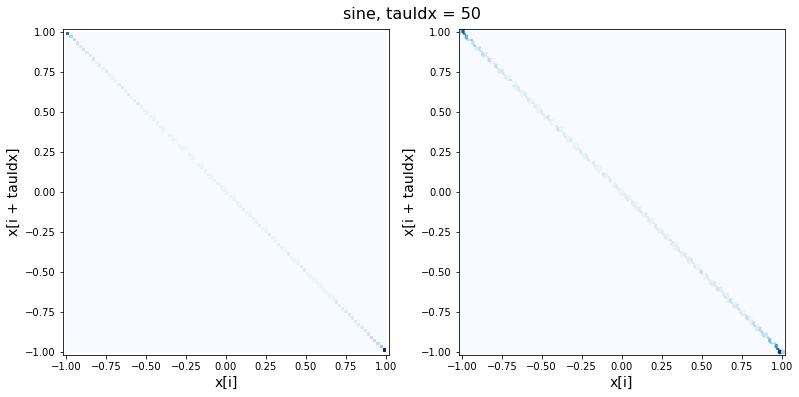

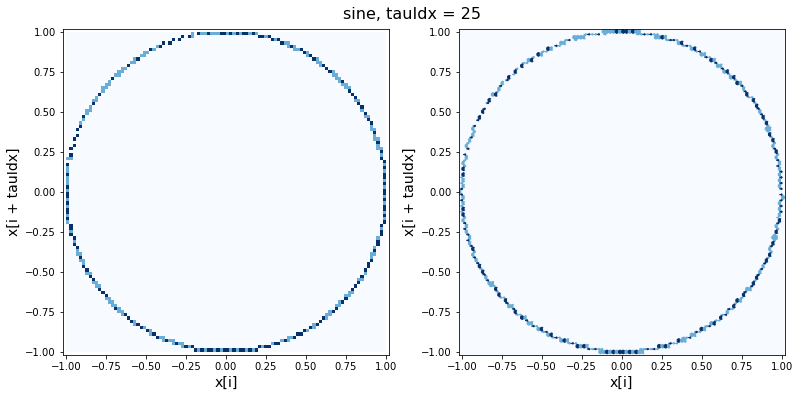

In [16]:
# test cases:
# sequential array
bin2D(timeSeries=np.arange(100),tauIdx=5,plotTitle="sequential, tauIdx = 5")
# random array
bin2D(timeSeries=np.random.randint(0,101,100),tauIdx=5,plotTitle="random, tauIdx = 5")
# correlated array
corr_arr = np.sin(np.linspace(0.,10.*np.pi,500))
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(corr_arr)
plt.show()
bin2D(timeSeries=corr_arr, tauIdx = 50, plotTitle="sine, tauIdx = 50") # non-optimal! 
bin2D(timeSeries=corr_arr, tauIdx = 25, plotTitle="sine, tauIdx = 25") # optimal! 50*n = perfect linear correlation

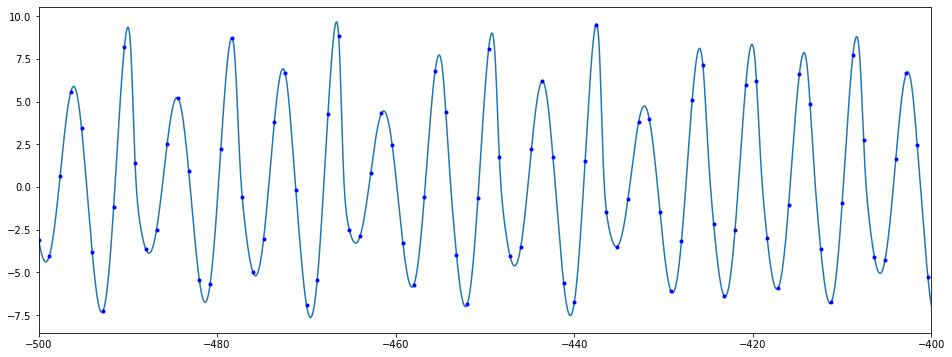

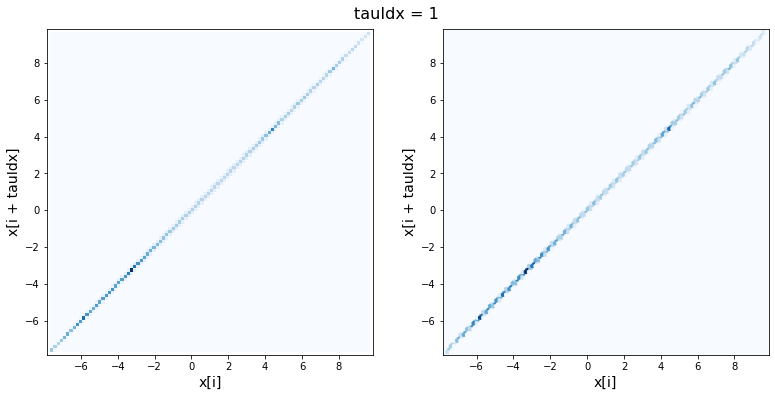

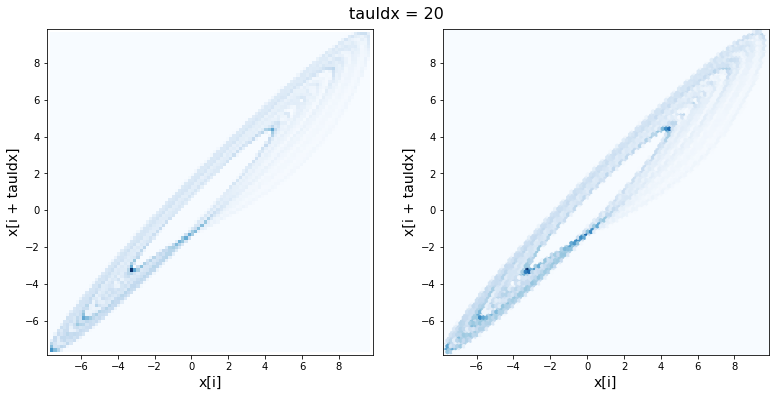

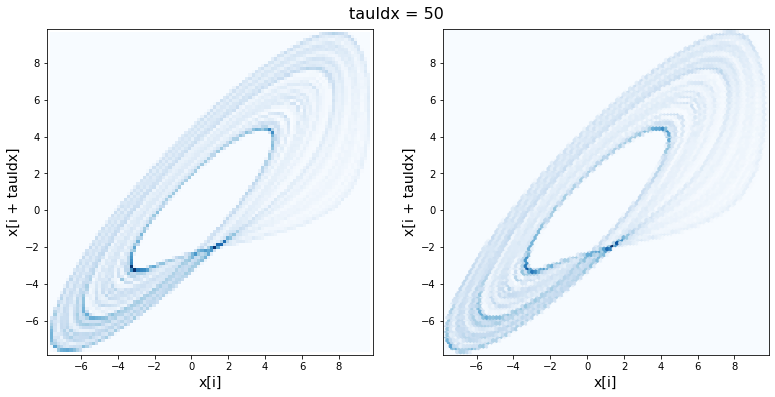

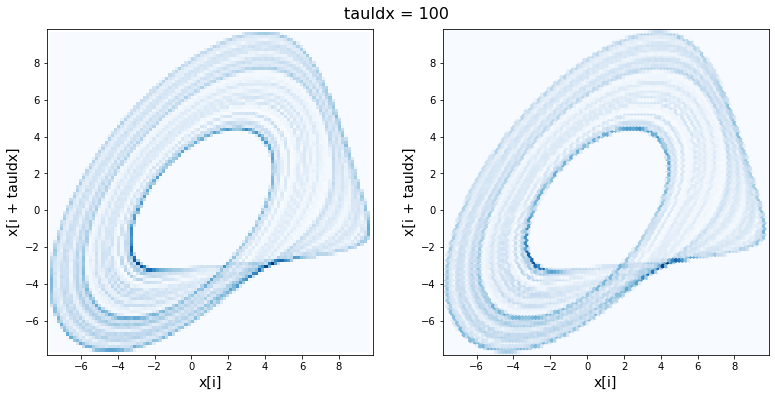

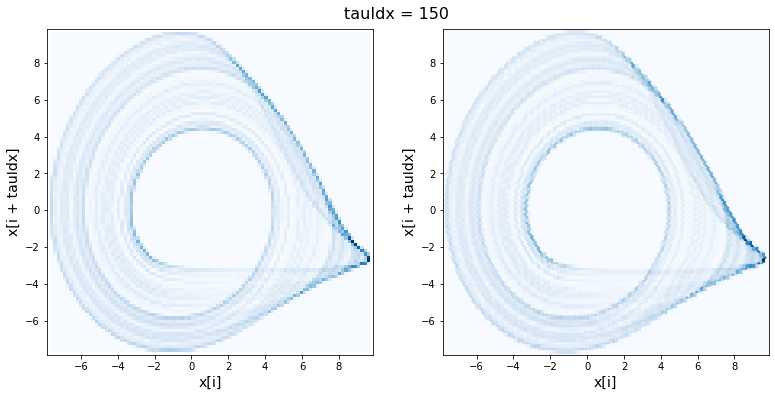

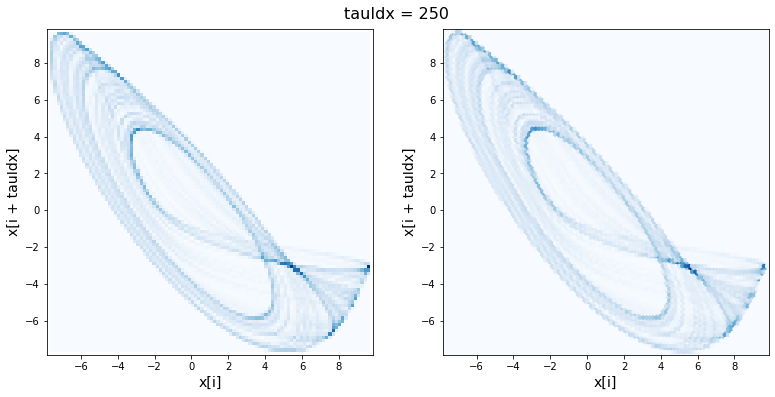

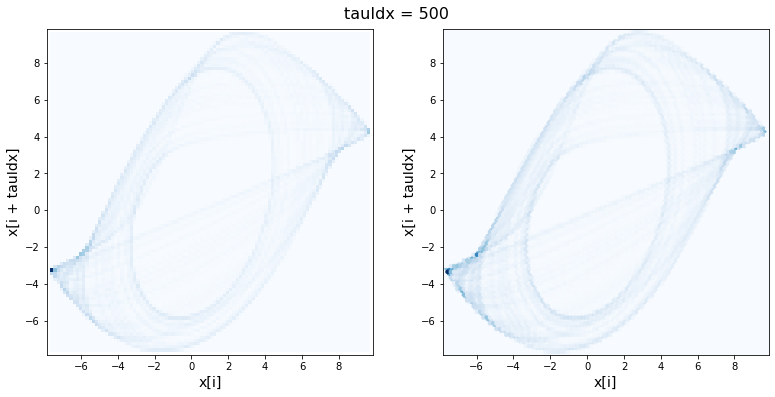

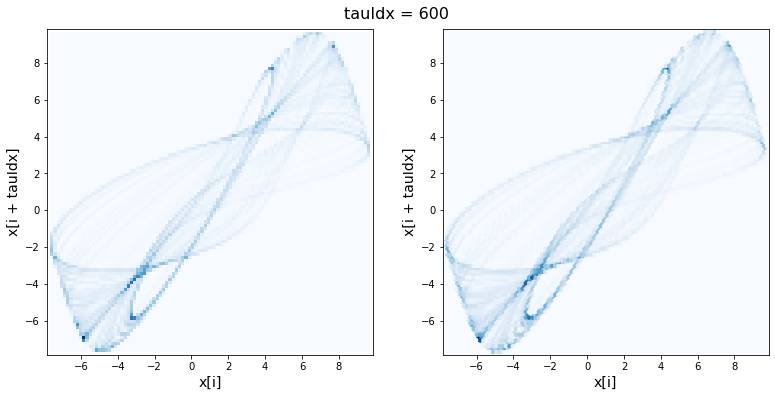

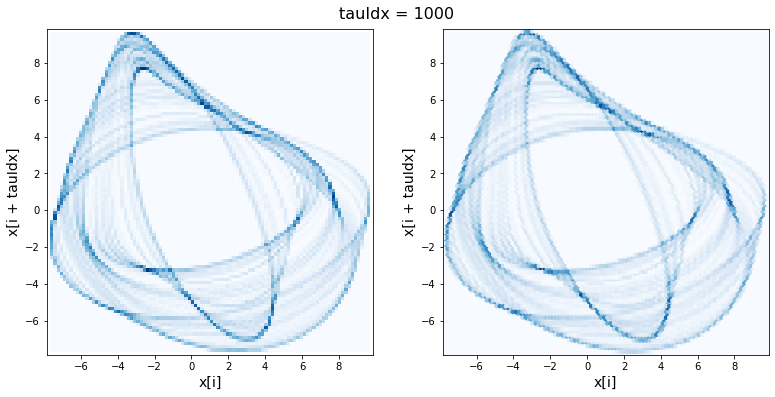

In [17]:
# rossler
testDelayIdxs = np.array((1,20,50,100,150,250,500,600,1000))
#testDelayIdxs = np.arange(1,201,10)
#testDelayIdxs = np.arange(110,130,10)
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(rossler_t,rossler_r[:,0])
#for i in testDelayIdxs:
#    ax.axvline(rossler_t[i],color='k')

# see where the nice-looking delays happen along the time series. remember: what makes a good delay is *minimal* correlation,
# not maximal! so the delay should not correspond to an inherent periodicity of the system.
delay = 120
ax.plot(rossler_t[::delay],rossler_r[::delay,0,],'b.')
ax.set_xlim(-500,-400)
plt.show()

for i in testDelayIdxs:
    bin2D(timeSeries=rossler_r[:,0], tauIdx = i, plotTitle="tauIdx = {0}".format(i))
#this is SO COOL
# so just by eye it looks like the first minimum of the mutual information should fall around tau~120 for the Rossler x 
# time series.

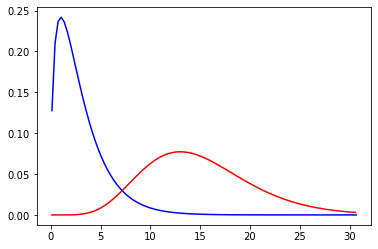

1.5472092253624832
1.287377140706061


In [18]:
#playing around with chi-squared test for significance of substructure in the joint probability distribution (see pages
# 5-6 of Fraser & Swinney 1986)
fig, ax = plt.subplots(1, 1)
x3 = np.linspace(chi2.ppf(0.01, df=3),chi2.ppf(0.999999, df=3), 100)
x15 = np.linspace(chi2.ppf(0.00000000000001, df=15),chi2.ppf(0.99, df=15), 100)
ax.plot(x3, chi2.pdf(x3, df=3),'b-')
ax.plot(x15, chi2.pdf(x15, df=15),'r-')
plt.show()

print(chi2.ppf(0.8,df=3)/3) #reduced chi squared (FS86 eq 21)
print(chi2.ppf(0.8,df=15)/15) #reduced chi squared (FS86 eq 22)


In [19]:
# steps:
# 1. binarize x(t) and y(t) = x(t + T), i.e. change of variables to s(t) and q(t) (see page 6)
#  "if the binary representations of s(t) and q(t) are available after the change of variable, then [s(t), q(t)] can be
#  assigned to the appropriate element of any partition G_m by inspection" --> how does this work?
#  i suppose because the partition is done by dividing into a grid of 4^m elements: each division corresponds to a power
#  of 2. the change of variables (x,y) -> (s,t) yields "sequences of known range and uniform density" which live in G_m.
#  conceptually I think I understand it but I want to make sure...it's the areas of the cells I guess that's tripping me up?
'''
def xy_to_sq(x,y):
    
    t = len(x)
    
    n = 0
    while 2**n < t:
        n+=1
        
    n_placeholder = 2**n - t
    # empty arrays
    xpad = np.zeros(2**n)
    ypad = np.zeros(2**n)
    
    # rather than zero-pad: make the beginning of the array a monotonic sequence, where the largest entry
    # is still smaller than the smallest real entry
    xpad[0:2**n - t] = np.linspace(np.min(x) - 2, np.min(x) - 1, 2**n - t)
    ypad[0:2**n - t] = np.linspace(np.min(y) - 2, np.min(y) - 1, 2**n - t)
    
    # end of xpad, ypad are the real entries
    xpad[-t:] = 1*x
    ypad[-t:] = 1*y
    
    # change of variables
    s = np.arange(2**n)[np.argsort(xpad)]
    q = np.arange(2**n)[np.argsort(ypad)]

    #print("xpad")
    #print(xpad)
    #print("ypad")
    #print(ypad)
    #print("s")
    #print(s)
    #print("q")
    #print(q)
    """
    fig,axes=plt.subplots(1,2,figsize=(13,6))
    
    axes[0].scatter(xpad,ypad,c=np.arange(len(xpad)),cmap='Blues',edgecolor='k',marker='.',s=200)
    axes[0].set_aspect('equal')
    axes[0].set_xlabel("xpad")
    axes[0].set_ylabel("ypad")
    axes[0].axhline(np.min(y) - 1,color='r')
    axes[0].axvline(np.min(x) - 1,color='r')
    
    axes[1].scatter(s,q,c=np.arange(len(s)),cmap='Blues',edgecolor='k',marker='.',s=200,zorder=10)
    axes[1].set_aspect('equal')
    axes[1].set_xlabel("s")
    axes[1].set_ylabel("q")
    axes[1].axhline(2**n - t - 1,color='r')
    axes[1].axvline(2**n - t - 1,color='r')
    
    for i in range(0,9):
        axes[1].axhline(4*i,color='b',lw=0.5)
        axes[1].axvline(4*i,color='b',lw=0.5)
    axes[1].set_xlim(-0.5,2**n+0.5)
    axes[1].set_ylim(-0.5,2**n+0.5)
    axes[1].set_title("points that fall on a grid line get assigned\nto the cell up &/ to the right of them")
    plt.show()
    """
    return s, q, n_placeholder

# 2. implement chi-squared tests (equations 21, 22) to decide if a cell is subdivided enough or not
def partition_chisq():
    return


# 3. implement equation (19) to evaluate  i_m (where m is the level of recursion). Call the previous routines to 
# decide if going to level m+1 is necessary.
def FS86(timeSeries, tauIdx):
    x = timeSeries[:-tauIdx]
    y = timeSeries[tauIdx:]
    #print(len(x))
    #print(len(y))
    #print(x)
    #print(y)
    
    N_0 = len(x) # number of (x,y) pairs
    
    s, q, n_placeholder = xy_to_sq(x,y)
    #print("n_placeholder is {0}".format(n_placeholder))
    t = len(s)
    
    #print(s)
    #print(q)
    #print(t)
    
    # G_0 = 2**0 x 2**0 = 1x1
    # G_1 = 2**1 x 2**1 = 2x2
    # G_2 = 2**2 x 2**2 = 4x4 etc
    
    m = 0
    # do the next two grid subdivisions
    
    # uniform partition
    grids = []
    I_seq = []
    for m in range(0,1):
        nCells = 2**(m+1)
        N_grid = np.zeros((nCells, nCells))
    
        for i in range(nCells):
            for j in range(nCells):
                cell_mask = (s >= i * (t/nCells)) & (s < (i+1) * (t/nCells)) & (q >= j * (t/nCells)) & (q < (j+1) * (t/nCells)) 
                N_grid[j,i] = len(s[cell_mask])
        # get rid of placeholder points
        N_grid[0,0] = N_grid[0,0] - n_placeholder
        I_m = -np.log(N_0)
        for i in range(nCells):
            for j in range(nCells): 
                I_m += (1./N_0) * (N_grid[i,j]*np.log(N_grid[i,j]))
                
        grids.append(N_grid)
        I_seq.append(I_m)
    """
    print(I_seq)
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.plot(I_seq,'k-')
    plt.show()
    """
    """    
    cax_xs = np.array((0.35,0.625,0.9))
    fig, axes = plt.subplots(1,3,figsize=(22,6))
    for i in range(0,3):
        im = axes[i].imshow(grids[i],cmap="Blues",origin="lower")
        axes[i].set_aspect("equal")
        cax = plt.axes([cax_xs[i], 0.1, 0.01, 0.8])
        plt.colorbar(im,cax=cax)
    plt.show()
    """
    
    return I_seq[0]
'''

'\ndef xy_to_sq(x,y):\n    \n    t = len(x)\n    \n    n = 0\n    while 2**n < t:\n        n+=1\n        \n    n_placeholder = 2**n - t\n    # empty arrays\n    xpad = np.zeros(2**n)\n    ypad = np.zeros(2**n)\n    \n    # rather than zero-pad: make the beginning of the array a monotonic sequence, where the largest entry\n    # is still smaller than the smallest real entry\n    xpad[0:2**n - t] = np.linspace(np.min(x) - 2, np.min(x) - 1, 2**n - t)\n    ypad[0:2**n - t] = np.linspace(np.min(y) - 2, np.min(y) - 1, 2**n - t)\n    \n    # end of xpad, ypad are the real entries\n    xpad[-t:] = 1*x\n    ypad[-t:] = 1*y\n    \n    # change of variables\n    s = np.arange(2**n)[np.argsort(xpad)]\n    q = np.arange(2**n)[np.argsort(ypad)]\n\n    #print("xpad")\n    #print(xpad)\n    #print("ypad")\n    #print(ypad)\n    #print("s")\n    #print(s)\n    #print("q")\n    #print(q)\n    """\n    fig,axes=plt.subplots(1,2,figsize=(13,6))\n    \n    axes[0].scatter(xpad,ypad,c=np.arange(len(xpad)),c

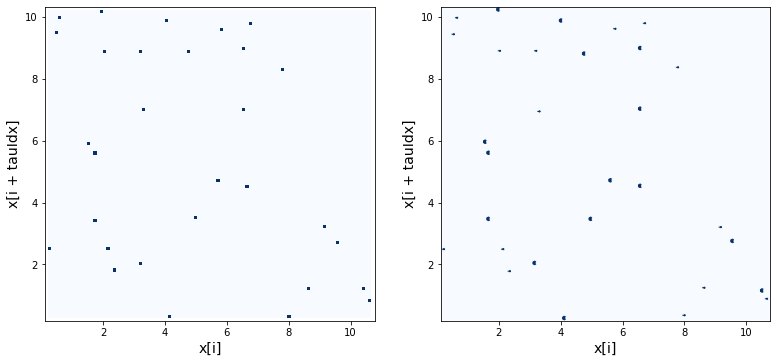

In [19]:
np.random.seed(42)
testRandom1 = np.random.uniform(0,11,size=128)

bin2D(timeSeries=testRandom1, tauIdx = 98,plotTitle=None)

#FS86(timeSeries=testRandom1,tauIdx = 98)

In [20]:
def calc_MI(X,Y,Xbins,Ybins):
    c_XY = np.histogram2d(X,Y,[Xbins,Ybins])[0]
    c_X = np.histogram(X,Xbins)[0]
    c_Y = np.histogram(Y,Ybins)[0]

    H_X = shan_entropy(c_X)
    H_Y = shan_entropy(c_Y)
    H_XY = shan_entropy(c_XY)

    MI = H_X + H_Y - H_XY
    return MI

def shan_entropy(c):
    c_normalized = c / float(np.sum(c))
    c_normalized = c_normalized[np.nonzero(c_normalized)]
    H = -sum(c_normalized* np.log2(c_normalized))  
    return H

def optimal_Nbins(X):
    """
    Implement Freedman-Diaconis rule for choosing optimal bin size / bin number:
    bin width = 2 * interquartile range * N**(-1/3)
    """
    bin_width = 2. * iqr(X) * (len(X)**(-1./3.))
    n_bins = int(np.ptp(X)/bin_width)
    return n_bins

In [21]:
MI = np.zeros((1000))

start = time.time()
for i in range(1000):
    #print(i)
    MI[i] = calc_MI(rossler_r[:-(i+1),0], rossler_r[(i+1):,0],Xbins=optimal_Nbins(rossler_r[:-(i+1),0]), Ybins = optimal_Nbins(rossler_r[(i+1):,0]))
end = time.time()
print((end - start)/1000.)

0.016400803804397582


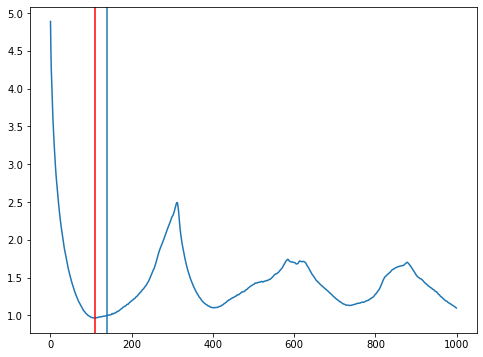

110


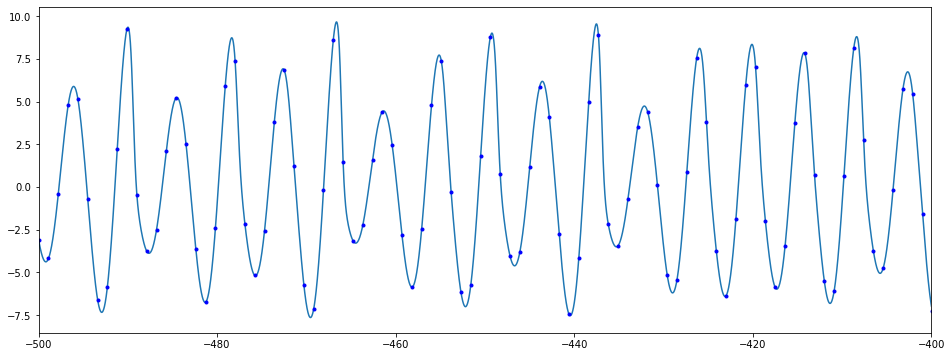

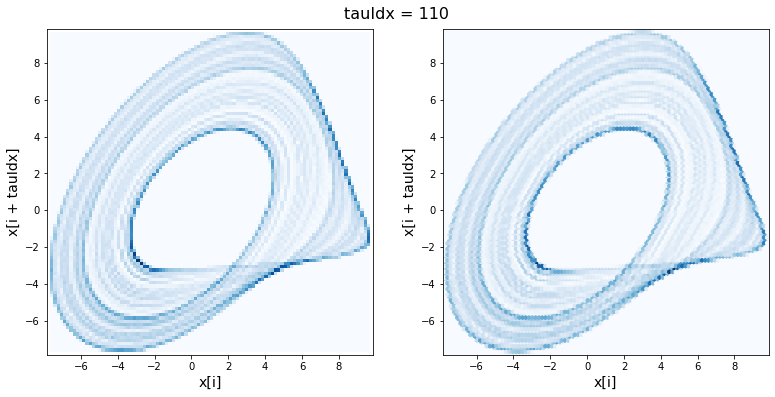

In [22]:
#expectation of first minimum, based on FS86
firstMin = ((193.3*(np.pi/100.)) * 0.23) * 100

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(MI)
ax.axvline(firstMin)
ax.axvline(np.argmin(MI[0:300]),color='r')
plt.show()
print(np.argmin(MI[0:300]))

fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(rossler_t,rossler_r[:,0])
#for i in testDelayIdxs:
#    ax.axvline(rossler_t[i],color='k')

# see where the nice-looking delays happen along the time series. remember: what makes a good delay is *minimal* correlation,
# not maximal! so the delay should not correspond to an inherent periodicity of the system.
delay = np.argmin(MI[0:300])
ax.plot(rossler_t[::delay],rossler_r[::delay,0,],'b.')
ax.set_xlim(-500,-400)
plt.show()
bin2D(timeSeries=rossler_r[:,0], tauIdx = np.argmin(MI[0:300]), plotTitle="tauIdx = {0}".format(np.argmin(MI[0:300])))


In [23]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def FS86(timeSeries, trialDelayIndices, plot=False):
    """
    Calculate the first local minimum of the mutual information as a function of delay time (in units of the cadence
    of the time series).

    Inputs:
    timeSeries (array-like): the time series on which to calculate the mutual information between pairs of delayed points
    trialDelayIndices (array-like): delay times (in units of time series cadence) to test
    
    Returns:
    MI (array-like, same shape as trialDelayIndices): each entry is the mutual information calculated at the respective
    choice of tau from trialDelayIndices
    firstLocalMinIdx (integer): index into MI of the first local minimum.
    
    """
    MI = np.zeros_like(trialDelayIndices,dtype=float)
    for i,tau in enumerate(trialDelayIndices):
        MI[i] = calc_MI(timeSeries[:-(tau+1)], timeSeries[(tau+1):],Xbins=optimal_Nbins(timeSeries[:-(tau+1)]), Ybins = optimal_Nbins(timeSeries[(tau+1):]))

    smooth_MI = moving_average(MI)
    localMinima = argrelextrema(smooth_MI, np.less)
    firstLocalMinIdx = localMinima[0][0]
    
    #check that the smoothing hasn't moved the index of the local minimum 
    for j in np.arange(-5,5):
        if MI[firstLocalMinIdx + j] < MI[firstLocalMinIdx]:
            firstLocalMinIdx = firstLocalMinIdx + j

    if plot is True:
        fig, ax = plt.subplots(1,1,figsize=(8,6))
        ax.plot(MI,'b-')
        ax.plot(smooth_MI,'g-')
        ax.axvline(x=firstLocalMinIdx,color='r')
        plt.show()
        
        bin2D(timeSeries=timeSeries, tauIdx = firstLocalMinIdx, plotTitle="tauIdx = {0}".format(firstLocalMinIdx))
    
    return MI, firstLocalMinIdx

start = time.time()
mutInfo, bestTau = FS86(timeSeries = rossler_r[:,0], trialDelayIndices = np.arange(500), plot=False)
end = time.time()
print((end - start)/500)
print(bestTau)

0.014975296020507813
109


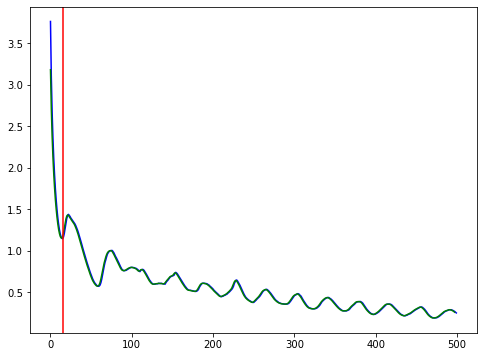

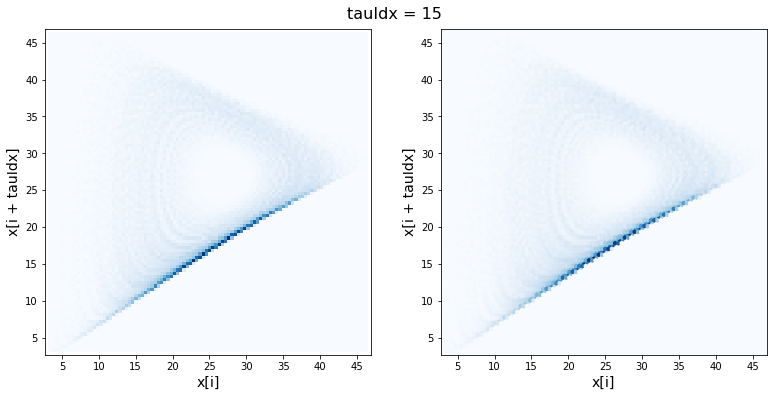

In [24]:
mutInfo, bestTau = FS86(timeSeries = lorenz_r[:,2], trialDelayIndices = np.arange(500), plot=True)

# Choose embedding dimension

### Cao 1997

In [25]:
def delayMatrix(timeSeries, tau, m):
    if m==1:
        return timeSeries
    else:
        N = len(timeSeries)
        firstDim = N - (m-1)*tau
        delayMat = np.zeros((firstDim, m))
        for i in range(m):
            delayMat[:,i] = timeSeries[(i*tau): (N - (m - 1 - i)*tau)]
        return delayMat

def nearestNeighborIndices(delayMatrix_m, delayMatrix_mp1):
    if delayMatrix_m.ndim == 1:
        nEntries = len(delayMatrix_m)
        m = 1
    else:
        nEntries, m = np.shape(np.atleast_2d(delayMatrix_m))
    
    nEntries_mp1 = np.shape(delayMatrix_mp1)[0]
    
    #print(nEntries)
    #print(m)
    #print(delayMatrix)
    nnI = np.zeros((nEntries_mp1),dtype=int)
    
    for i in range(nEntries_mp1):
        #print("i is {0}".format(i))
        nn = (i+1) % nEntries_mp1
        #print("nn is {0}".format(nn))
        #print(delayMatrix[i])
        #print(delayMatrix[nn])
        compDist = chebyshev(delayMatrix_m[i], delayMatrix_m[nn])
        #print(compDist)
        #print("i is {0}".format(i))
        #print(compDist)
        for j in range(nEntries_mp1):
            #print(j)
            if j == i:
                pass
            else:
                chebyshevDist = chebyshev(delayMatrix_m[i],delayMatrix_m[j])
                if chebyshevDist < compDist:
                    #print("better")
                    #print(chebyshevDist)
                    compDist = chebyshevDist
                    nn = j
                    #print("new nn is {0}".format(nn))
        #print("nn is {0}".format(nn))
        nnI[i] = nn
    return nnI


def cao97(timeSeries, tau, mMax):
    
    # mMax - 1 because we're not bothering with m = 1
    E = np.zeros((mMax), dtype=float)
    E1 = np.zeros((mMax),dtype=float)
    E1[0] = 0.
    Estar = np.zeros((mMax), dtype=float)
    E2 = np.zeros((mMax),dtype=float)
    E2[0] = 0.
    
    # E must range up to mMax+2 because E1, E2 calculations require m + 1
    for m in range(2,mMax+2):
        delayMat_m = delayMatrix(timeSeries, tau, m)
        delayMat_mp1 = delayMatrix(timeSeries, tau, m+1)
        
        # find indices of nearest neighbors--this is the slowest step so far, scales as n_datapoints^2
        start = time.time()
        nnIndices = nearestNeighborIndices(delayMat_m,delayMat_mp1)
        end = time.time()
        
        print("time taken: {0}".format(end - start))
        
        # calculate a[i, m] and populate E[m]
        a = np.zeros_like(nnIndices, dtype=float)
        for i in range(len(a)):
            a[i] = chebyshev(delayMat_mp1[i], delayMat_mp1[nnIndices[i]])/chebyshev(delayMat_m[i], delayMat_m[nnIndices[i]])
        
        E[m-2] = np.mean(a)
        
        # calculate equation 4 and populate Estar[m]
        b = np.zeros_like(nnIndices, dtype=float)
        for i in range(len(a)):
            b[i] = np.abs(timeSeries[i + m*tau] - timeSeries[nnIndices[i] + m*tau])
        Estar[m-2] = np.mean(b)
        
    
    for m in range(0,mMax-1):
        E1[m+1] = E[m+1]/E[m]
        E2[m+1] = Estar[m+1]/Estar[m]
        
    return E1, E2

time taken: 120.54691886901855
time taken: 128.30313897132874
time taken: 127.59591007232666
time taken: 115.91107892990112
time taken: 110.5144419670105
time taken: 102.05327320098877
time taken: 83.21426486968994
time taken: 74.51596117019653


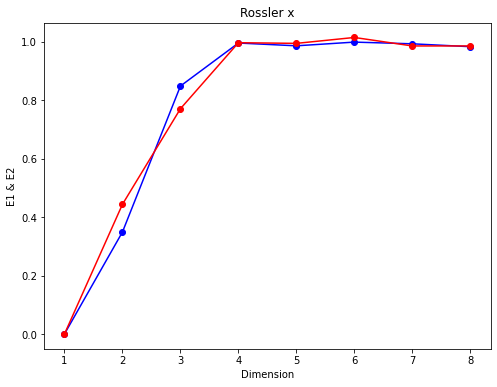

In [26]:
#going to be too slow to run on O(10^4) data points---will need to cythonize
# of order 1 second per m for 1000 entries but scales as N^2
E1, E2 = cao97(timeSeries = rossler_r[:5000,0], tau = 109, mMax = 8)

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,9),E1,'bo',ls='-')
ax.plot(np.arange(1,9),E2,'ro',ls='-')
ax.set_title('Rossler x')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
plt.show()

time taken: 81.71044111251831
time taken: 79.14285898208618
time taken: 83.40334677696228
time taken: 72.81102418899536
time taken: 70.43319487571716
time taken: 66.71435189247131
time taken: 63.31301403045654
time taken: 60.56038308143616


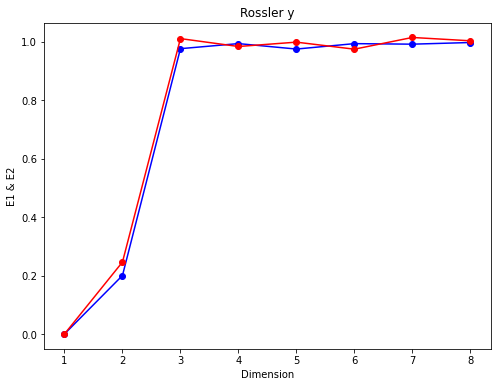

In [27]:
#going to be too slow to run on O(10^4) data points---will need to cythonize
# of order 1 second per m for 1000 entries but scales as N^2
E1, E2 = cao97(timeSeries = rossler_r[:5000,1], tau = 149, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,9),E1,'bo',ls='-')
ax.plot(np.arange(1,9),E2,'ro',ls='-')
ax.set_title('Rossler y')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
plt.show()

time taken: 78.43096399307251
time taken: 75.38744688034058
time taken: 71.08032989501953
time taken: 67.27226710319519
time taken: 63.188698291778564
time taken: 59.91656231880188
time taken: 54.44934296607971
time taken: 51.11480498313904


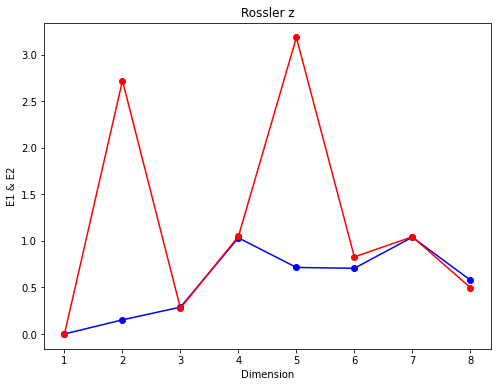

In [28]:
#going to be too slow to run on O(10^4) data points---will need to cythonize
# of order 1 second per m for 1000 entries but scales as N^2
E1, E2 = cao97(timeSeries = rossler_r[:5000,2], tau = 183, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,9),E1,'bo',ls='-')
ax.plot(np.arange(1,9),E2,'ro',ls='-')
ax.set_title('Rossler z')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
plt.show()

time taken: 81.86577081680298
time taken: 79.64255928993225
time taken: 77.71200013160706
time taken: 74.90560102462769
time taken: 72.16842985153198
time taken: 69.2825767993927
time taken: 66.45075488090515
time taken: 63.87052083015442


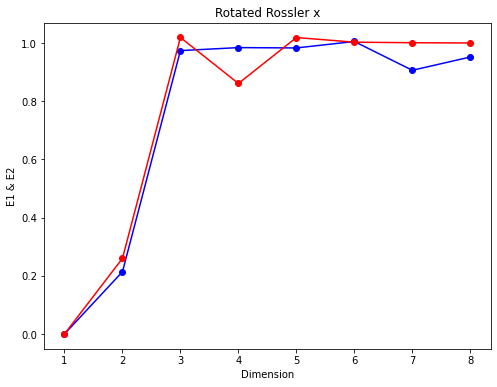

In [29]:
#going to be too slow to run on O(10^4) data points---will need to cythonize
# of order 1 second per m for 1000 entries but scales as N^2
E1, E2 = cao97(timeSeries = rotated_rossler_r[:5000,0], tau = 138, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,9),E1,'bo',ls='-')
ax.plot(np.arange(1,9),E2,'ro',ls='-')
ax.set_title('Rotated Rossler x')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
plt.show()

time taken: 81.60368919372559
time taken: 81.20896291732788
time taken: 78.49637413024902
time taken: 75.39012598991394
time taken: 73.1467068195343
time taken: 70.94873976707458
time taken: 68.38161206245422
time taken: 65.1315016746521


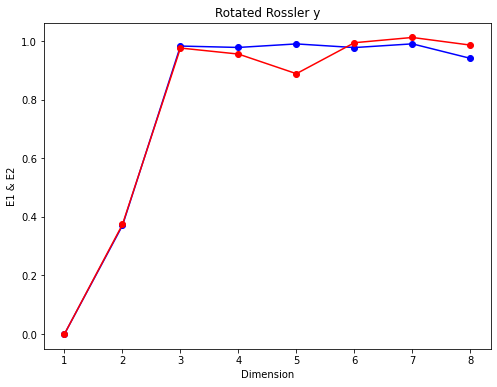

In [30]:
#going to be too slow to run on O(10^4) data points---will need to cythonize
# of order 1 second per m for 1000 entries but scales as N^2
E1, E2 = cao97(timeSeries = rotated_rossler_r[:5000,1], tau = 134, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,9),E1,'bo',ls='-')
ax.plot(np.arange(1,9),E2,'ro',ls='-')
ax.set_title('Rotated Rossler y')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
plt.show()

time taken: 81.79140186309814
time taken: 77.67927598953247
time taken: 79.11521291732788
time taken: 71.35774636268616
time taken: 67.5278148651123
time taken: 64.03017377853394
time taken: 60.60190510749817
time taken: 57.303828954696655


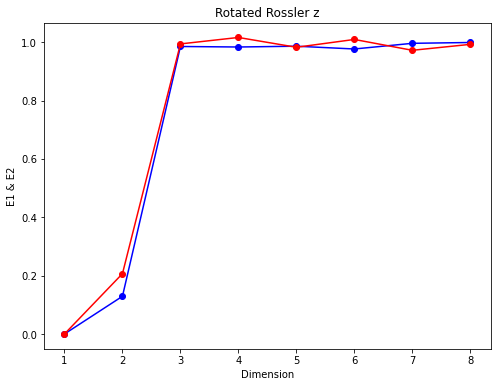

In [31]:
#going to be too slow to run on O(10^4) data points---will need to cythonize
# of order 1 second per m for 1000 entries but scales as N^2
E1, E2 = cao97(timeSeries = rotated_rossler_r[:5000,2], tau = 162, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,9),E1,'bo',ls='-')
ax.plot(np.arange(1,9),E2,'ro',ls='-')
ax.set_title('Rotated Rossler z')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
plt.show()

time taken: 90.54224801063538
time taken: 93.09105110168457
time taken: 96.58978390693665
time taken: 98.26142907142639
time taken: 100.01517176628113
time taken: 102.80375790596008
time taken: 103.6859130859375
time taken: 107.6745867729187


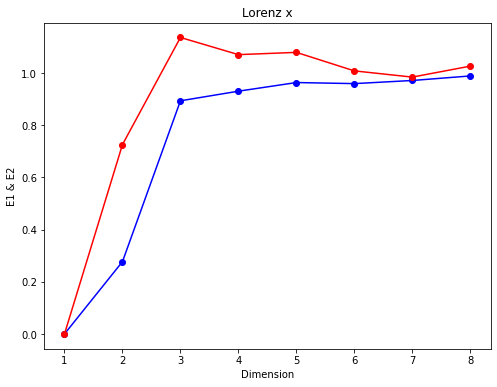

In [32]:
#going to be too slow to run on O(10^4) data points---will need to cythonize
# of order 1 second per m for 1000 entries but scales as N^2
E1, E2 = cao97(timeSeries = lorenz_r[:5000,0], tau = 15, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,9),E1,'bo',ls='-')
ax.plot(np.arange(1,9),E2,'ro',ls='-')
ax.set_title('Lorenz x')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
plt.show()

time taken: 90.62343907356262
time taken: 93.01850819587708
time taken: 95.55997371673584
time taken: 98.56768822669983
time taken: 100.51029086112976
time taken: 102.47652816772461
time taken: 112.69456791877747
time taken: 113.4842791557312


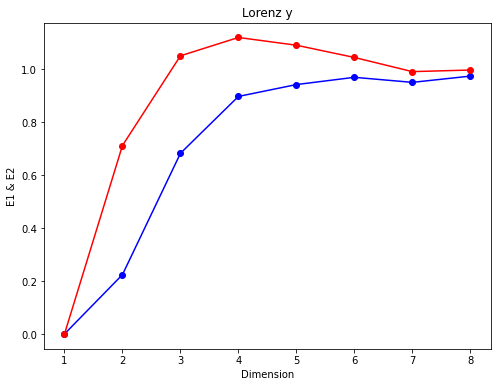

In [33]:
#going to be too slow to run on O(10^4) data points---will need to cythonize
# of order 1 second per m for 1000 entries but scales as N^2
E1, E2 = cao97(timeSeries = lorenz_r[:5000,1], tau = 14, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,9),E1,'bo',ls='-')
ax.plot(np.arange(1,9),E2,'ro',ls='-')
ax.set_title('Lorenz y')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
plt.show()

time taken: 89.92204403877258
time taken: 94.00500798225403
time taken: 96.05201721191406
time taken: 97.87068200111389
time taken: 100.25167393684387
time taken: 102.2276599407196
time taken: 103.37038016319275
time taken: 107.09020805358887


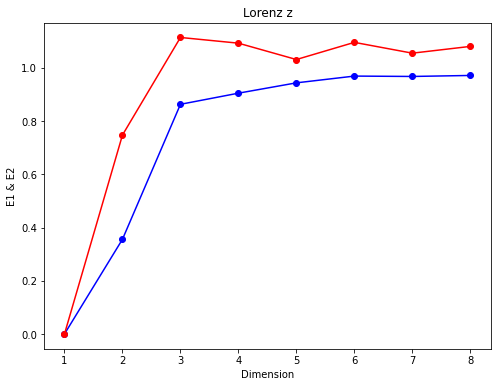

In [34]:
#going to be too slow to run on O(10^4) data points---will need to cythonize
# of order 1 second per m for 1000 entries but scales as N^2
E1, E2 = cao97(timeSeries = lorenz_r[:5000,2], tau = 15, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,9),E1,'bo',ls='-')
ax.plot(np.arange(1,9),E2,'ro',ls='-')
ax.set_title('Lorenz z')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
plt.show()

time taken: 79.8260087966919
time taken: 77.05408215522766
time taken: 74.48803806304932
time taken: 71.55445718765259
time taken: 67.74407768249512
time taken: 63.98278188705444
time taken: 60.60553193092346
time taken: 58.09810495376587


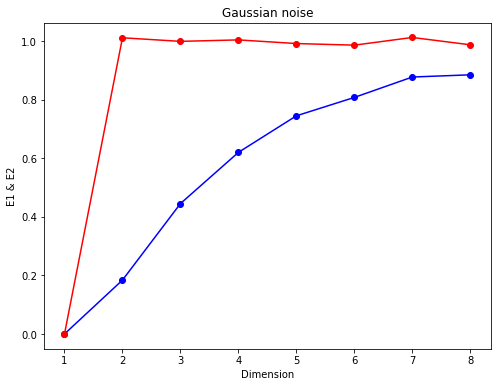

In [35]:
#going to be too slow to run on O(10^4) data points---will need to cythonize
# of order 1 second per m for 1000 entries but scales as N^2
E1, E2 = cao97(timeSeries = gaussianNoise[:5000], tau = 162, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,9),E1,'bo',ls='-')
ax.plot(np.arange(1,9),E2,'ro',ls='-')
ax.set_title('Gaussian noise')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
plt.show()

time taken: 80.13865399360657
time taken: 77.37391710281372
time taken: 73.81729412078857
time taken: 71.04252028465271
time taken: 67.45569181442261
time taken: 63.80904698371887
time taken: 60.05387806892395
time taken: 57.10769510269165


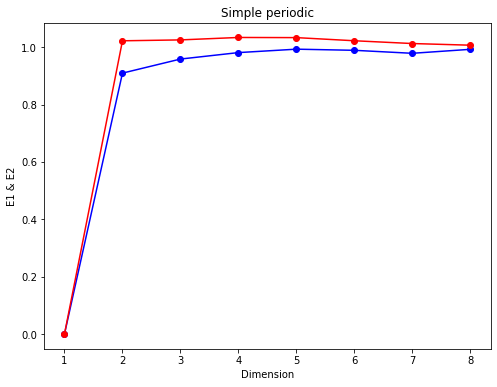

In [36]:
E1, E2 = cao97(timeSeries = simplePeriodic[:5000], tau = 162, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,9),E1,'bo',ls='-')
ax.plot(np.arange(1,9),E2,'ro',ls='-')
ax.set_title('Simple periodic')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
plt.show()

time taken: 80.4924590587616
time taken: 77.11414408683777
time taken: 73.97744178771973
time taken: 70.8685839176178
time taken: 69.16928505897522
time taken: 64.71101808547974
time taken: 60.378763914108276
time taken: 56.96095275878906


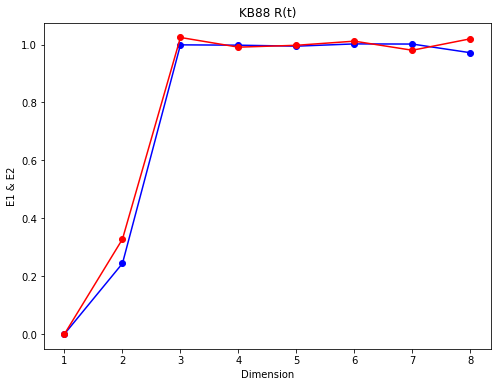

In [37]:
E1, E2 = cao97(timeSeries = multiPeriodic_r[:5000], tau = 162, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,9),E1,'bo',ls='-')
ax.plot(np.arange(1,9),E2,'ro',ls='-')
ax.set_title('KB88 R(t)')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
plt.show()

time taken: 79.55381989479065
time taken: 77.1198251247406
time taken: 73.75968408584595
time taken: 70.89654803276062
time taken: 67.09467577934265
time taken: 64.16476321220398
time taken: 61.71227693557739
time taken: 56.895922899246216


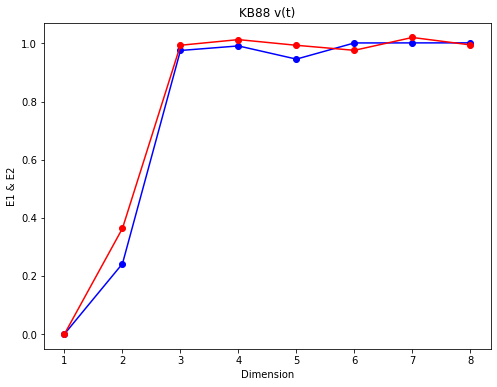

In [38]:
E1, E2 = cao97(timeSeries = multiPeriodic_v[:5000], tau = 162, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,9),E1,'bo',ls='-')
ax.plot(np.arange(1,9),E2,'ro',ls='-')
ax.set_title('KB88 v(t)')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
plt.show()

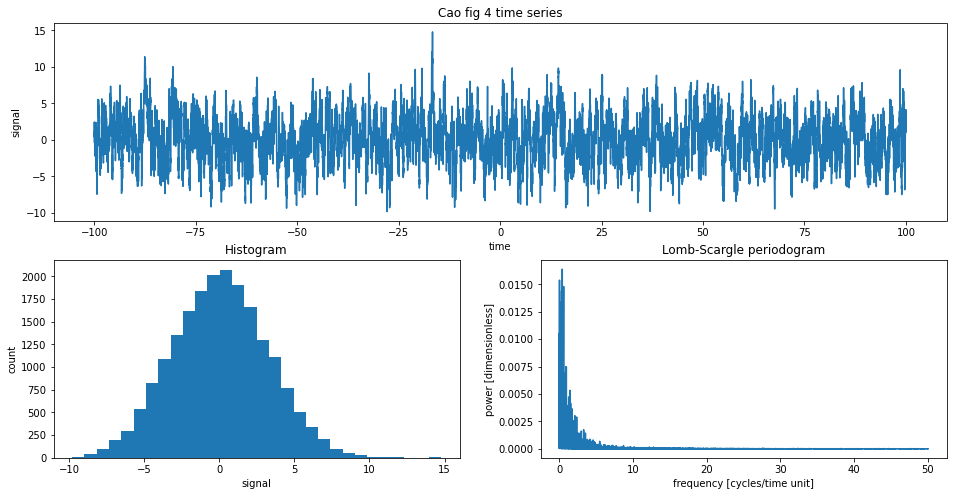

time taken: 114.07569909095764
time taken: 114.6620409488678
time taken: 143.16696095466614
time taken: 134.74243593215942
time taken: 136.157222032547
time taken: 134.5671751499176
time taken: 136.49831128120422
time taken: 164.72321820259094


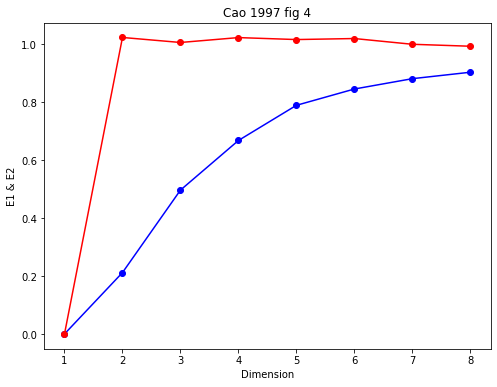

In [47]:
# reproduce Cao 1997 fig 4

np.random.seed(8421)

dt = 0.01
tmin = -100.
tmax = 100.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

gaussianNoise2 = np.random.normal(0.,1.,len(t))

caoFig4 = np.zeros_like(t)
caoFig4[0] = gaussianNoise2[0]
for i in range(1, len(t)):
    caoFig4[i] = caoFig4[i-1]*0.95 + gaussianNoise2[i]
plotTimeSeries(t, caoFig4,min_freq=(1./baseline),max_freq=(1./(2.*dt)),title="Cao fig 4")

# Cao used tau = 1 for this data, because it's a map rather than a continous diff EQ
E1, E2 = cao97(timeSeries = caoFig4[:5000], tau = 1, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,9),E1,'bo',ls='-')
ax.plot(np.arange(1,9),E2,'ro',ls='-')
ax.set_title('Cao 1997 fig 4')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
plt.show()

# Calculate correlation integral

### Grassberger & Procaccia 1983